# Ajuste de dados - Modelo Van Genuchten - Umidade no solo

Modelo Van Genuchten (1980):

$$
\theta(\psi) = \theta_r+(\theta_s-\theta_r)[1+(\alpha|\psi|)^n]^{-m}
$$

onde $\psi$ é o potencial mátrico, $\theta_r$ a umidade residual, $\theta_s$ a umidade de saturação, $\alpha$, $n$ e $m$ parâmetros a serem ajustados. Uma simplificação considerável do modelo é considerar $m=1-1/n$.

In [273]:
import sys, os, time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing, fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
pd.options.plotting.backend = "plotly"

Dados experimentais do artigo Dani Or

In [274]:
df = pd.read_csv('dados1.csv', sep = ';', decimal=',')

## Visualização dos dados

* Pandas 
* Plotly
* Numpy

In [275]:
df.head()

,h,U
0,0.01,0.418
1,1.00,0.396
2,2.00,0.364
3,3.00,0.335
4,5.00,0.295


Convertendo os dados da lista para vetores

In [276]:
h = df.h.to_numpy()
T = df.U.to_numpy()
print(h.shape, T.shape)

(9,) (9,)


Função - Van Genuchten (1980)

In [277]:
def VG(x, a, n, Tr, Ts): 
    f = Tr+(Ts-Tr)/(1+(a*x)**n)**(1-1/n)
    return f

Soma do erro quadrático

In [278]:
def SSE(T,Tp):
    J = ((Tp - T)**2).sum()
    return J

In [279]:
# Constroi gráfico com os dados experimentais e a partir dos parâmetros estimados manualmente
def plot_guess(a, n, Tr, Ts):
    linha_x = np.linspace(h.min(), h.max(),num=10000)
    linha_y = VG(linha_x, a, n, Tr, Ts)
    Tp = np.array(VG(h, a, n, Tr, Ts))
    J = SSE(T,Tp) #calculo do SSE
    fig = px.scatter(df, x='h', y='U', title=f'SSE: {J}', height=600, log_x=True)
    fig.add_trace(go.Scatter(
        x=linha_x,
        y=linha_y,
        mode="lines",
        line=go.scatter.Line(color="red"),
        showlegend=False))
    fig.data = (fig.data[0],fig.data[1])
    fig.show()

Condições iniciais

In [280]:
interact(plot_guess, a=widgets.FloatSlider(min=0, max=2, step=0.01, value=0.36), n=widgets.FloatSlider(min=1, max=3, step=0.01, value=1.49), Tr=widgets.FloatSlider(min=0, max=2, step=0.01, value=0.04), Ts=widgets.FloatSlider(min=0, max=2, step=0.01, value=0.41, continuous_update=False))

interactive(children=(FloatSlider(value=0.36, description='a', max=2.0, step=0.01), FloatSlider(value=1.49, de…

<function __main__.plot_guess(a, n, Tr, Ts)>

# Ajuste não linear por PLS

In [281]:
#Chute inicial
a=1.5
n=1.1
Tr=0.99
Ts=0.40
p0=[a, n, Tr, Ts]

In [282]:
#Calculo do SSE inicial
Tp=VG(h,a,n,Tr,Ts)
erro1=SSE(T,Tp)
print(erro1)

1.1070097956741332


In [283]:
#Ajuste não linear
popt, pcov, infodict, mesg, ier = curve_fit(VG, h, T, p0, bounds=((0, 1, 0, 0.4), (2, 5.0, 1.0, 0.6)), full_output = True)

In [284]:
infodict

{'nfev': 15,
 'fvec': array([ 0.00149035, -0.00094799, -0.0010122 , -0.00046156, -0.00360665,
         0.00678039, -0.00342087, -0.00324418,  0.00442272])}

In [285]:
#Calculo do SSE final
ae, ne, Tre, Tse = popt
Tp=VG(h,ae, ne, Tre, Tse)
erro2=SSE(T,Tp)
print(erro2)

0.00010512660997932867


In [286]:
#coeficientes
print(popt)

[0.36530613 1.49228319 0.03798574 0.41951936]


In [287]:
def plot_reg():
    a,n,Tr,Ts=popt
    linha_x = np.linspace(h.min()*0.6, h.max()*1.5,num=10000)
    linha_y = VG(linha_x, a, n, Tr, Ts)
    Tp = np.array(VG(h, a, n, Tr, Ts))
    J = SSE(T,Tp) #calculo do SSE
    fig = px.scatter(df, x='h', y='U', title=f'SSE: {J}', height=600, log_x=True)
    fig.add_trace(go.Scatter(
        x=linha_x,
        y=linha_y,
        mode="lines",
        line=go.scatter.Line(color="red"),
        showlegend=False))
    fig.data = (fig.data[0],fig.data[1])
    fig.show()

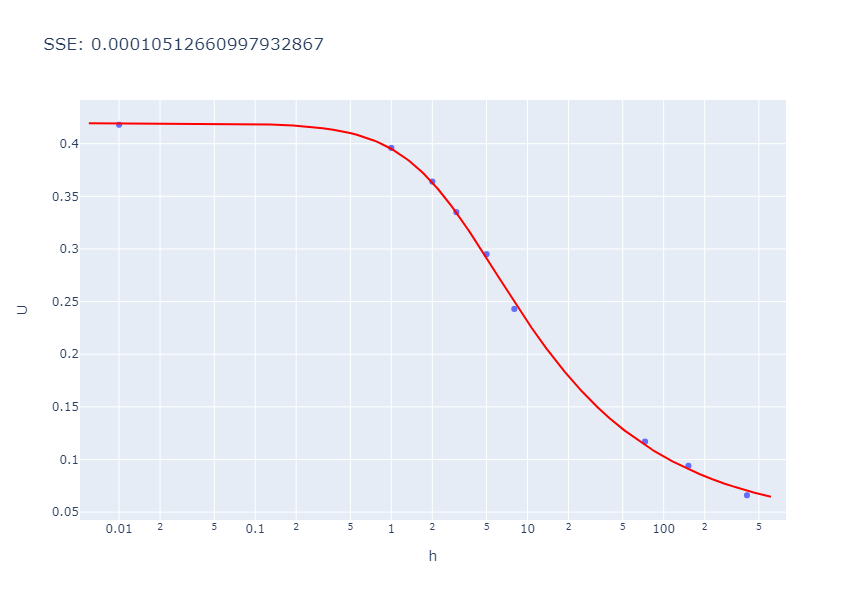

In [288]:
plot_reg()

In [289]:
#matriz de covariância
print(pcov)

[[ 1.08360360e-03 -1.42010730e-03 -2.53882457e-04  9.86885905e-05]
 [-1.42010730e-03  2.72435552e-03  5.55770582e-04 -9.19128078e-05]
 [-2.53882457e-04  5.55770582e-04  1.26419385e-04 -1.61961011e-05]
 [ 9.86885905e-05 -9.19128078e-05 -1.61961011e-05  1.66487928e-05]]


In [290]:
#erro absoluto nos parâmetros
erroa=np.sqrt(np.diag(pcov))
#erro relativo nos parâmetros
error=(erroa/popt)*100
print(erroa)
print(error)

[0.03291813 0.05219536 0.01124364 0.00408029]
[ 9.01110941  3.49768458 29.59963078  0.97261142]


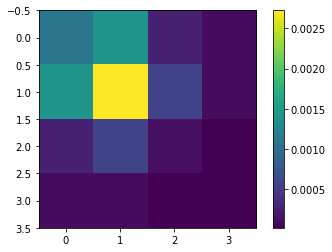

In [291]:
#Análise do erro
plt.imshow(np.abs(pcov))
plt.colorbar()
plt.show()

In [ ]:
#Análise do erro absoluto
plt.imshow(np.abs(pcov))
plt.colorbar()
plt.show()

## Comentário

